In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

from utils.RegressionOrdinalizer import RegressionOrdinalizer

from utils.Consumer_Habits_file_loader import load_consumer_habits



# Goal:  
>## Identify variables that have the most influence on Review Ratings  
Consumer reviews and ratings affect sales: such as through product placement. So, the variables that influence Review Ratings are important. Moreover, as AI drives automation, I imagine pipelines that monitor review ratings will only grow in importance. For example, a Jan 2026 Forbes article mentions that the future of [ChatGPT] advertising will be built around relevance and credibility. Reviews have potential to measure both.  

### Reference:  
DeBoe, T. (2026, January 27). *ChatGPT Ads Just Changed The Rules Of Marketing Forever*. https://www.forbes.com/sites/terdawn-deboe/2026/01/26/chatgpt-ads-just-changed-the-rules-of-marketing-forever/.  
Sipka, A. (2025, December 23). *Why is Optimal Product Ranking Important for E‑Commerce Businesses*. https://www.luigisbox.com/blog/what-is-product-ranking/   

There is more information available on this subject. However, this is a toy data set and the information it provides is restrictive. Such as that it isn't explicit whether or not it is a stratified sample or a uniform sample. It appears to be uiform  (or uniform synthetic data); hence, an exaustive study is not worthwile.  

# Findings:  
## Overall "Review Ratings" are not spectacular.   
They are most related to "Color", "Location", and "Shipping Type".  


>### Next steps this data might lead to, enable, or enhance:  
> Identify market position, such as with SWOT framework  
> Set goals that are realistic, such as with SMART framework  
> I dentify Key Performance Indicators (KPIs) that are good indicators of progress toward the goals.  
> Build a Data Pipeline that monitors KPIs  

In [2]:
#load data
df=load_consumer_habits()


/home/lelandmesford/Projects/Consumer_Habits/utils/Consumer_Habits_file_loader.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Male']=df['Gender'].replace({'Male':1,'Female':0}).astype('object')


## A look at distribution  

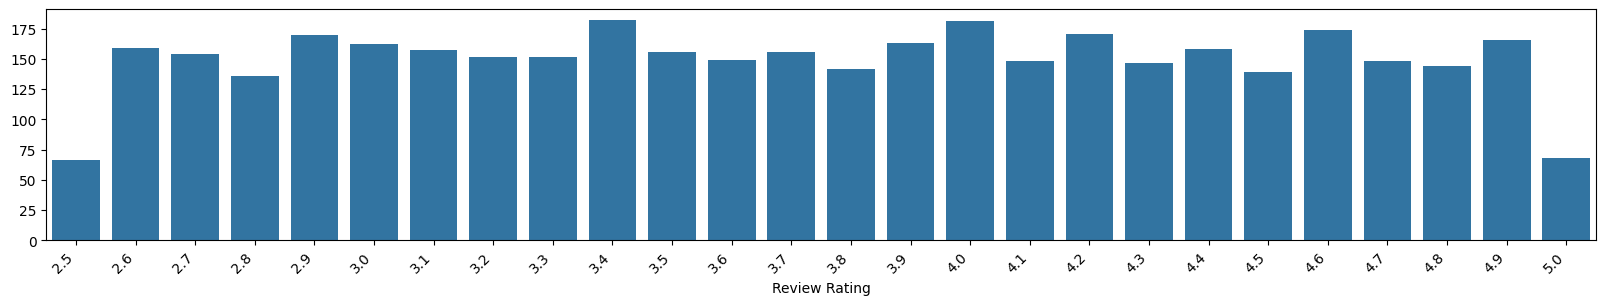

In [4]:
#a look at the distribution
plot_data=df['Review Rating'].value_counts()
plt.figure(figsize=(20,3))
sns.barplot(x=plot_data.index,y=plot_data.values)
plt.xticks(rotation=45,ha='right')
plt.show()


### **Observation:** The reviews seem to follow a uniform distribution  


## A look at 'Review Rating' by Binned Category  

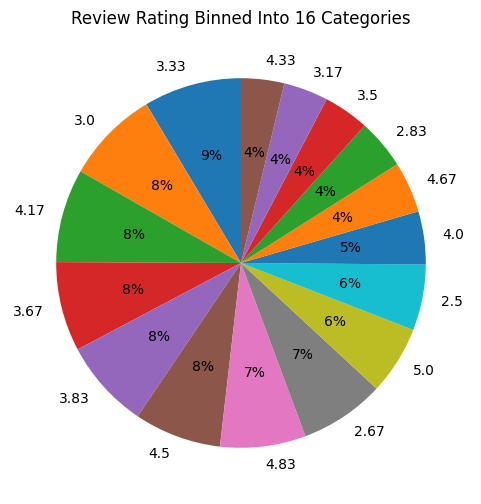

In [4]:
counts = df['Review Rating_Binned'].value_counts()

plt.figure(figsize=(6,6))
plt.pie( counts.values,  labels=counts.index,  autopct='%1.0f%%', startangle=90 )
plt.title(f'Review Rating Binned Into {len(counts)} Categories')
plt.show()

# =======================================
# A statistical analysis of Review Rating 
# ======================================= 

### Analysisy of hypothosis tests == H1 (reject null)

In [5]:
from utils.CompareColumns import CompareColumns
cc=CompareColumns()
test_df=cc.column_comparison(df,
                        numnum_meth_alpha_above=None, 
                        catnum_meth_alpha_above=('kruskal',0.05,False),  
                        catcat_meth_alpha_above=('chi2',0.05,False),  
                        numeric_columns=None,
                        categoric_columns=None,
                        numeric_target='Review Rating',
                        categoric_target=None ).sort_values(by='P-value',ascending=True).round(4)
test_df=test_df.loc[(~test_df['column_b'].str.startswith('Review Rating'))].reset_index(drop=True)
test_df

,column_a,column_b,test,P-value
0,Review Rating,Color,kruskal,0.0118
1,Review Rating,Purchase Amount (USD)_Ordinalized,kruskal,0.0335
2,Review Rating,Shipping Type,kruskal,0.0390
3,Review Rating,Size,kruskal,0.0434


### Bin Review Ratings for easier interprability  

In [6]:
# columns to review in relation to Review Rating
counter_columns = list(test_df['column_b'].values)

In [7]:
from utils.BinnerClass import Bin
bin=Bin()
bin.relational_binner(df[counter_columns+['Review Rating']], numnum_meth_alpha_above=('welch',0.05, False),  catnum_meth_alpha_above=('kruskal',0.05,False),    
                    original_value_count_threashold=5,   numeric_columns=None,  categoric_columns=None,   numeric_target='Review Rating',   categoric_target=None  )  
print("Abs min bins: ",bin.numeric_target_column_minimums)
for k,v in bin.numeric_feature_col_thresholds['Review Rating'].items():
    print(k,': Min bins within threshold: ',v['min_within_threshold'])

Abs min bins:  {'Review Rating': 16}
Shipping Type : Min bins within threshold:  7
Color : Min bins within threshold:  4
Size : Min bins within threshold:  16
Purchase Amount (USD)_Ordinalized : Min bins within threshold:  5


Statistical analysis indicate that Review Rating can be binned into 7 levels for most columns, but needs to be binned into 16 levels for 'Size'

In [8]:
# create 2 new columns for 7 and 16 levels of review ratings
df['Review Rating 7 Levels']=bin.binner(df['Review Rating'],7, rescale=False, return_bins=False)
df['Review Rating 16 Levels']=bin.binner(df['Review Rating'],16, rescale=False, return_bins=False)

In [ ]:
import utils.utils_Analyze_Reviews as utls

# Use Charts to examine Review Rating levels across categories that have regected null hypothesises 

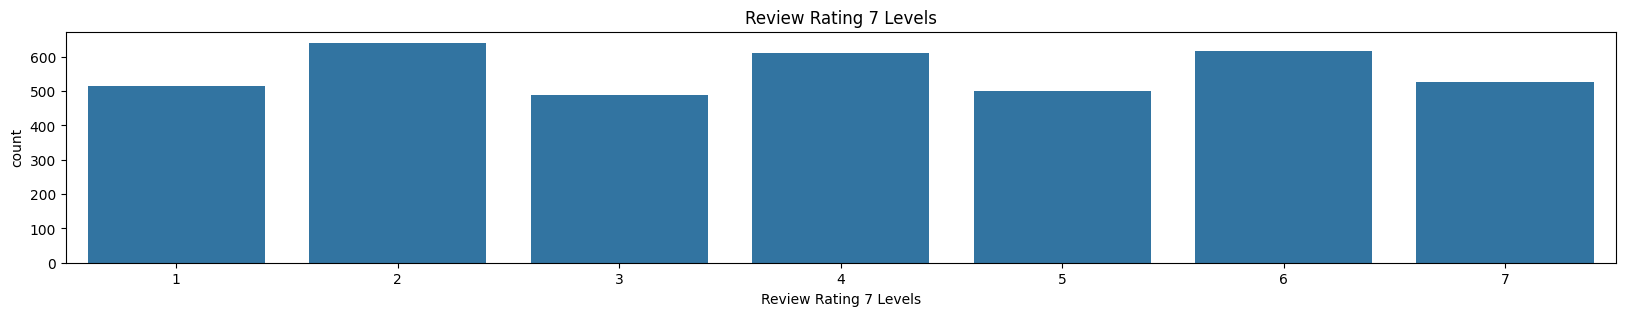

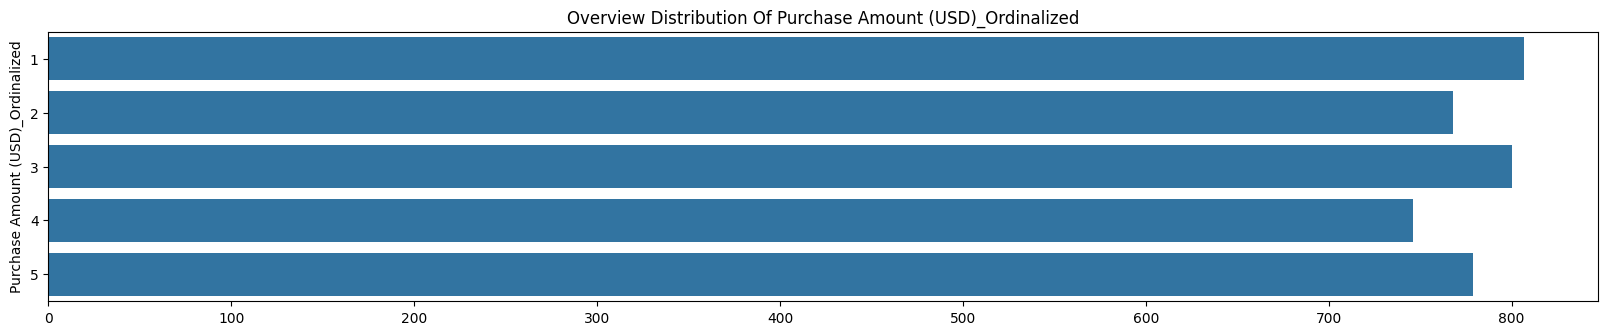

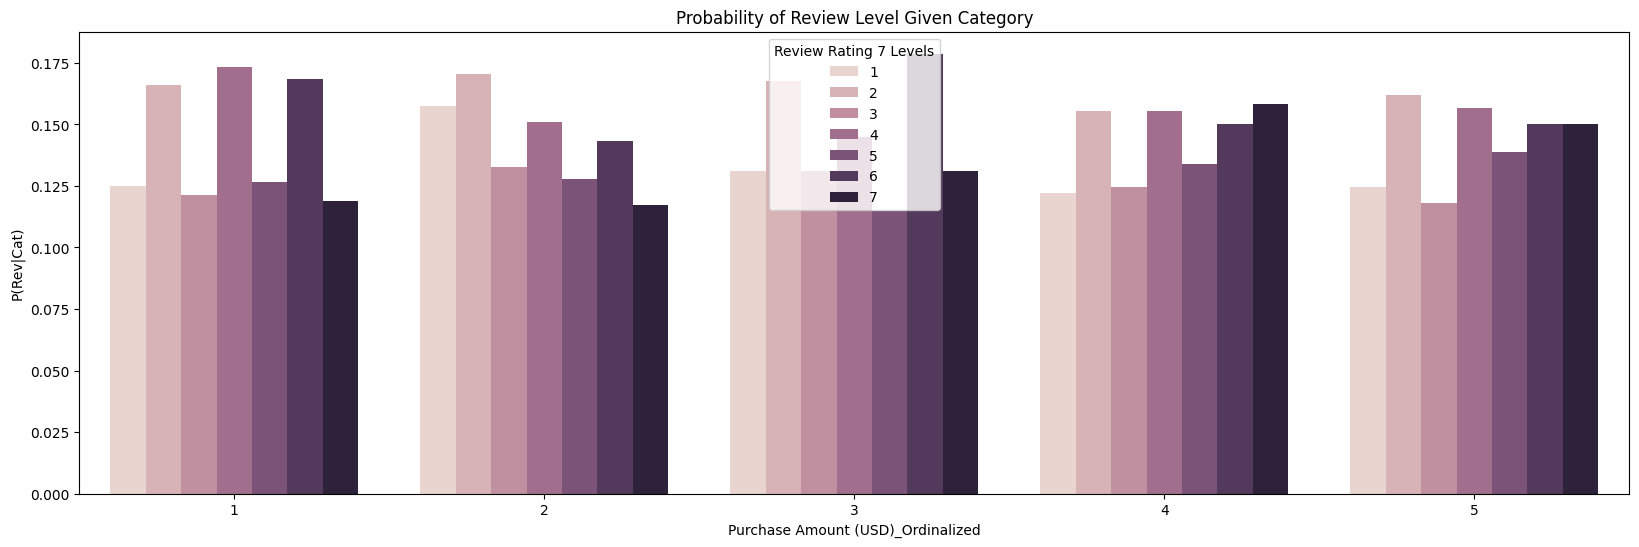

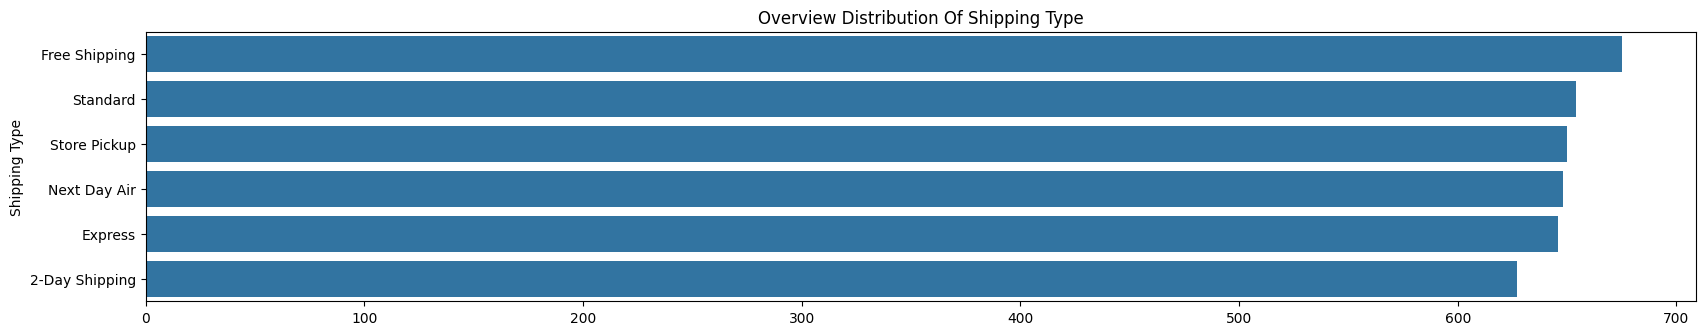

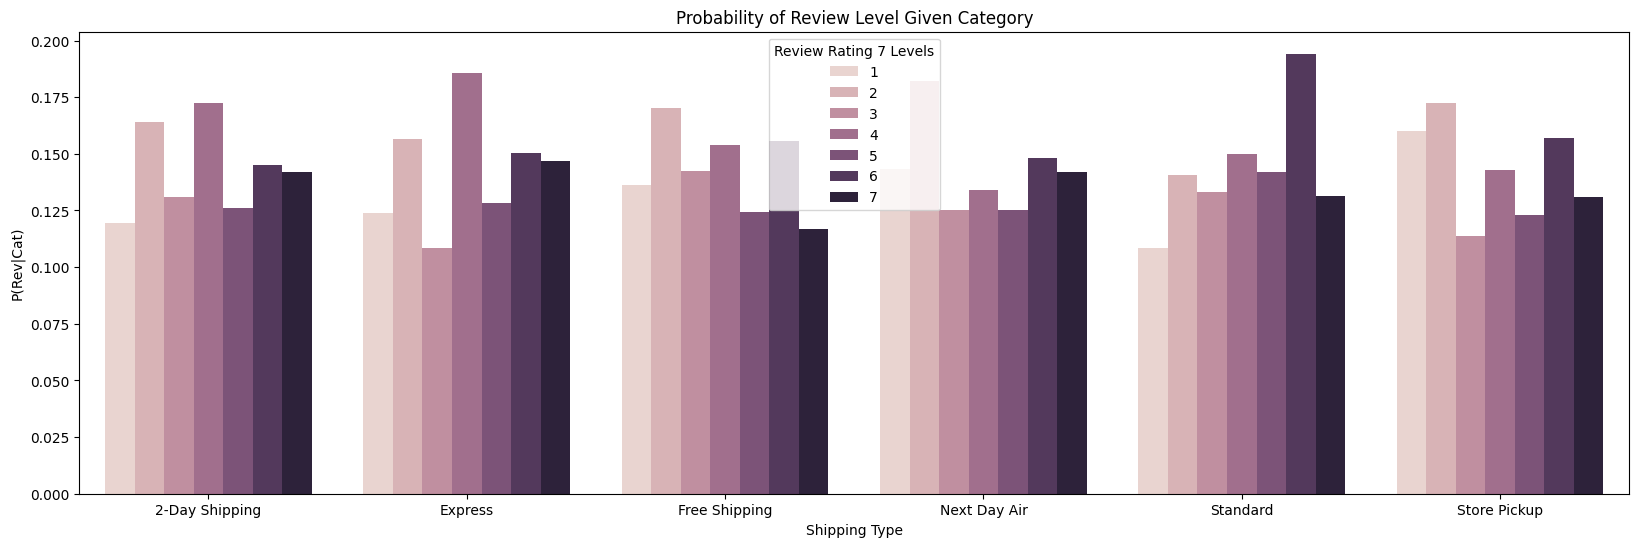

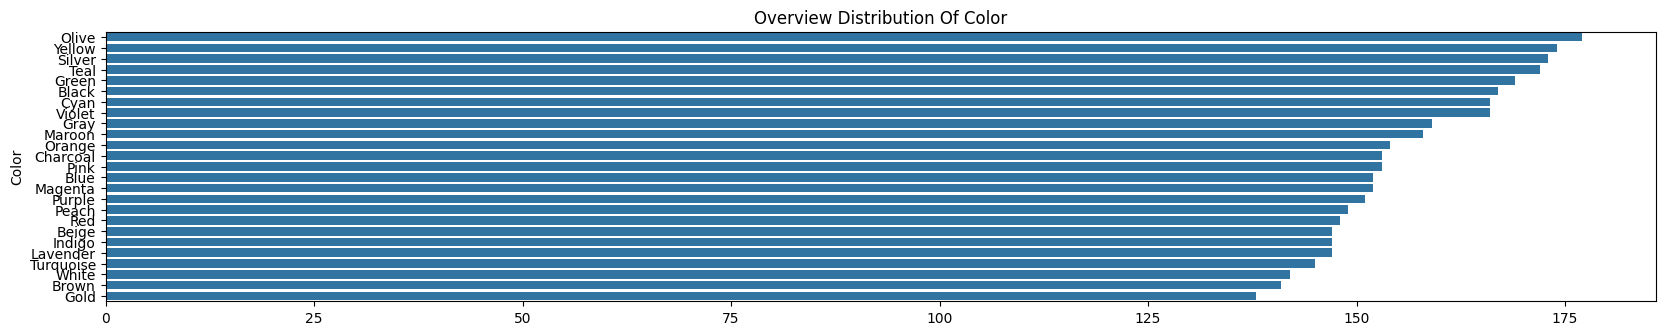

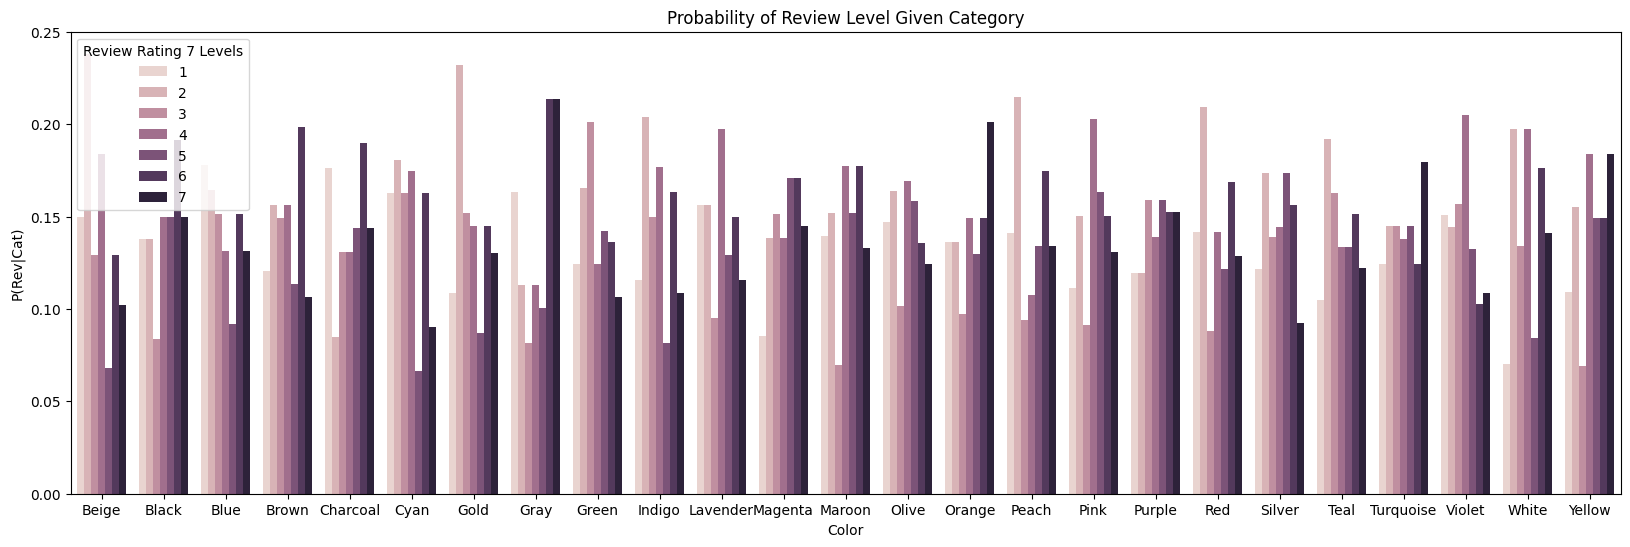

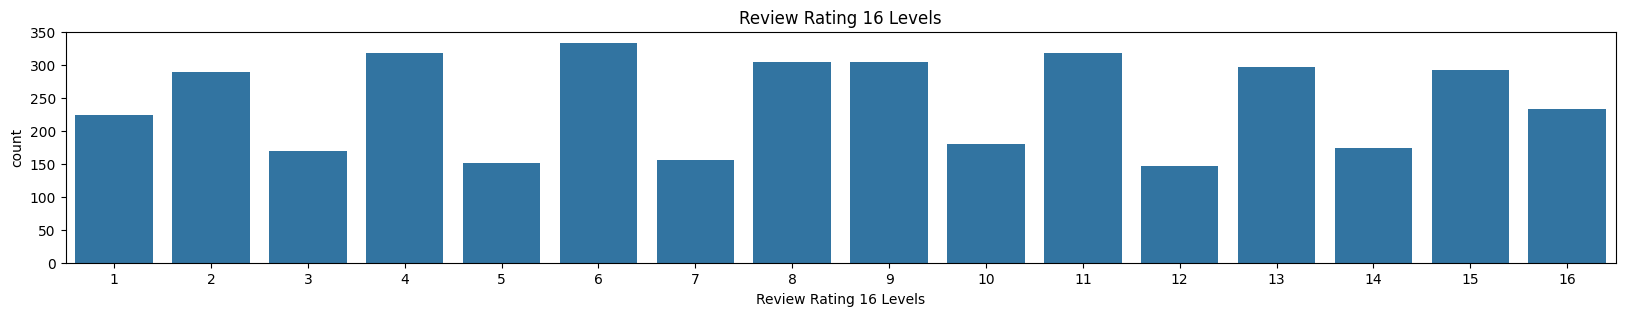

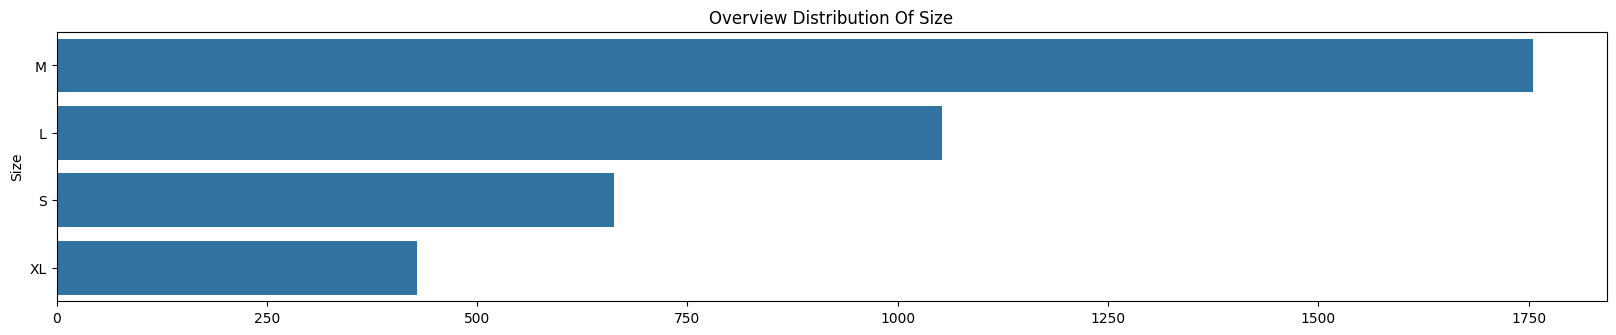

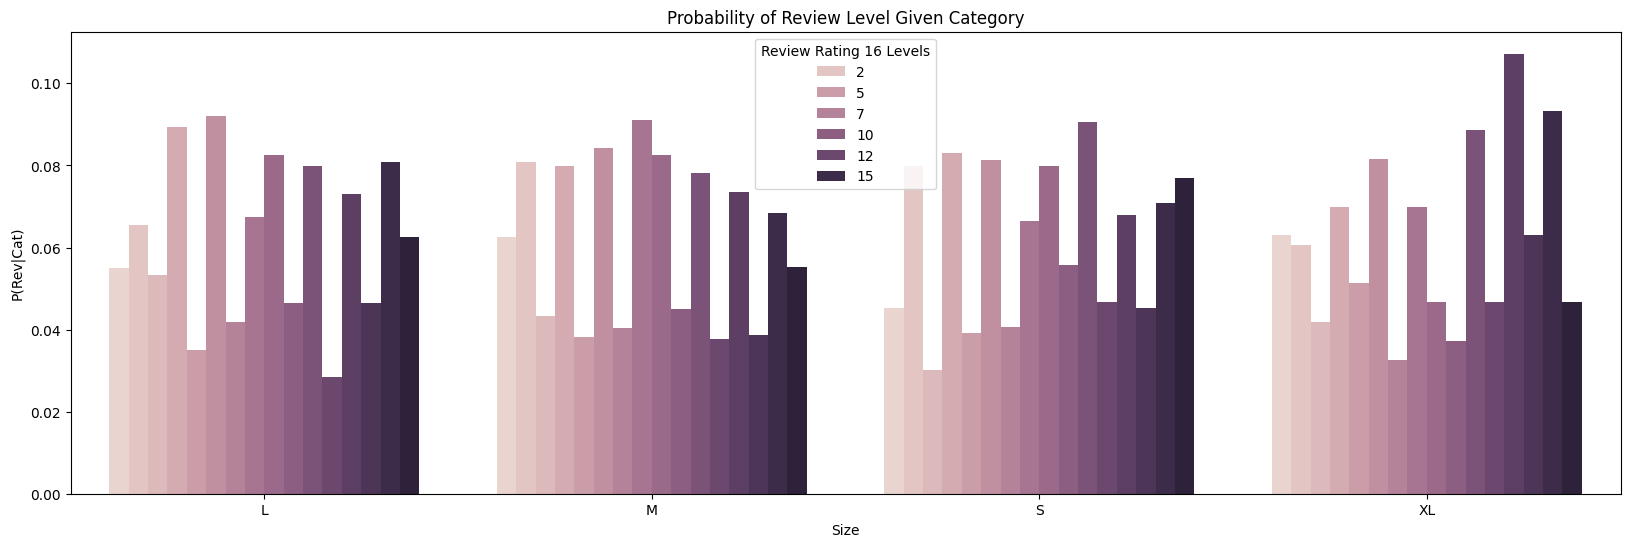

In [12]:
plt.figure(figsize=(20,3))
plt.title('Review Rating 7 Levels')
sns.countplot(data=df,x='Review Rating 7 Levels',orientation='vertical')
plt.show()
for col in ['Purchase Amount (USD)_Ordinalized', 'Shipping Type']:
    utls.plot_cat_to_review_levels(df, col,  'Review Rating 7 Levels', probabilities=True,
                              detail_plots=False, n_axis_columns=4,  use_log=False,  dist_overview=True)
    
utls.plot_cat_to_review_levels(df, 'Color', 'Review Rating 7 Levels',  probabilities=True,
                              detail_plots=False, n_axis_columns=4,  use_log=False,  dist_overview=True)
plt.figure(figsize=(20,3))
plt.title('Review Rating 16 Levels')
sns.countplot(data=df,x='Review Rating 16 Levels',orientation='vertical')
plt.show()
utls.plot_cat_to_review_levels(df, 'Size',  'Review Rating 16 Levels',  probabilities=True,
                              detail_plots=False, n_axis_columns=4,  use_log=False,  dist_overview=True)


### Observation: There are a lot of spikes in probability of a category receiveing a review rating for certain levels    
> Purchase Amount (USD)_Ordinalized shows spikes in levels 1-3 for all purchase categories, but only spikes in high revies for categories 1, 3, and 4.  
>  Standard shipping spikes for higher reviews, but most other Shipping Types spike for lower reviews.  
> Many colors have high bias for high or low review levels.   
> There is a slight tendency for L sizes to spike in low review levels and XL to spike in high. Otherwise, for M and S, spikes are not especially biased.

# =======================================
# Use predictive models to analyze Review Rating
# ======================================= 

### Ordinalize categorical variables and build predictive models  

In [ ]:
regAna=RegressionOrdinalizer()
df=regAna.create_ordinalized_columns(df, 'Review Rating', feature_columns=None, center=None, rank=True, mode_trunc=['decimal',2,10])

In [ ]:
regression_df=df[['Age', 'Male',  'Purchase Amount (USD)',
                     'Review Rating',
                    'Subscription Status', 'Discount Applied',
                    'Promo Code Used', 'Previous Purchases', 
                    'Total Days of Patronage',
                    'Purchase Amount (USD)_Binned', 'Purchase Amount (USD)_Ordinalized',
                    'Total Days of Patronage_Binned', 'Total Days of Patronage_Ordinalized',
                    'Review Rating_Binned', 'Review Rating_Ordinalized', 'Age_Binned',
                    'Age_Ordinalized', 'Previous Purchases_Binned',
                    'Previous Purchases_Ordinalized', 'Male_Ordinalized',
                    'Item Purchased_Ordinalized', 'Category_Ordinalized',
                    'Location_Ordinalized', 'Size_Ordinalized', 'Color_Ordinalized',
                    'Season_Ordinalized', 'Subscription Status_Ordinalized',
                    'Shipping Type_Ordinalized', 'Discount Applied_Ordinalized',
                    'Promo Code Used_Ordinalized', 'Payment Method_Ordinalized',
                    'Frequency of Purchases_Ordinalized']]


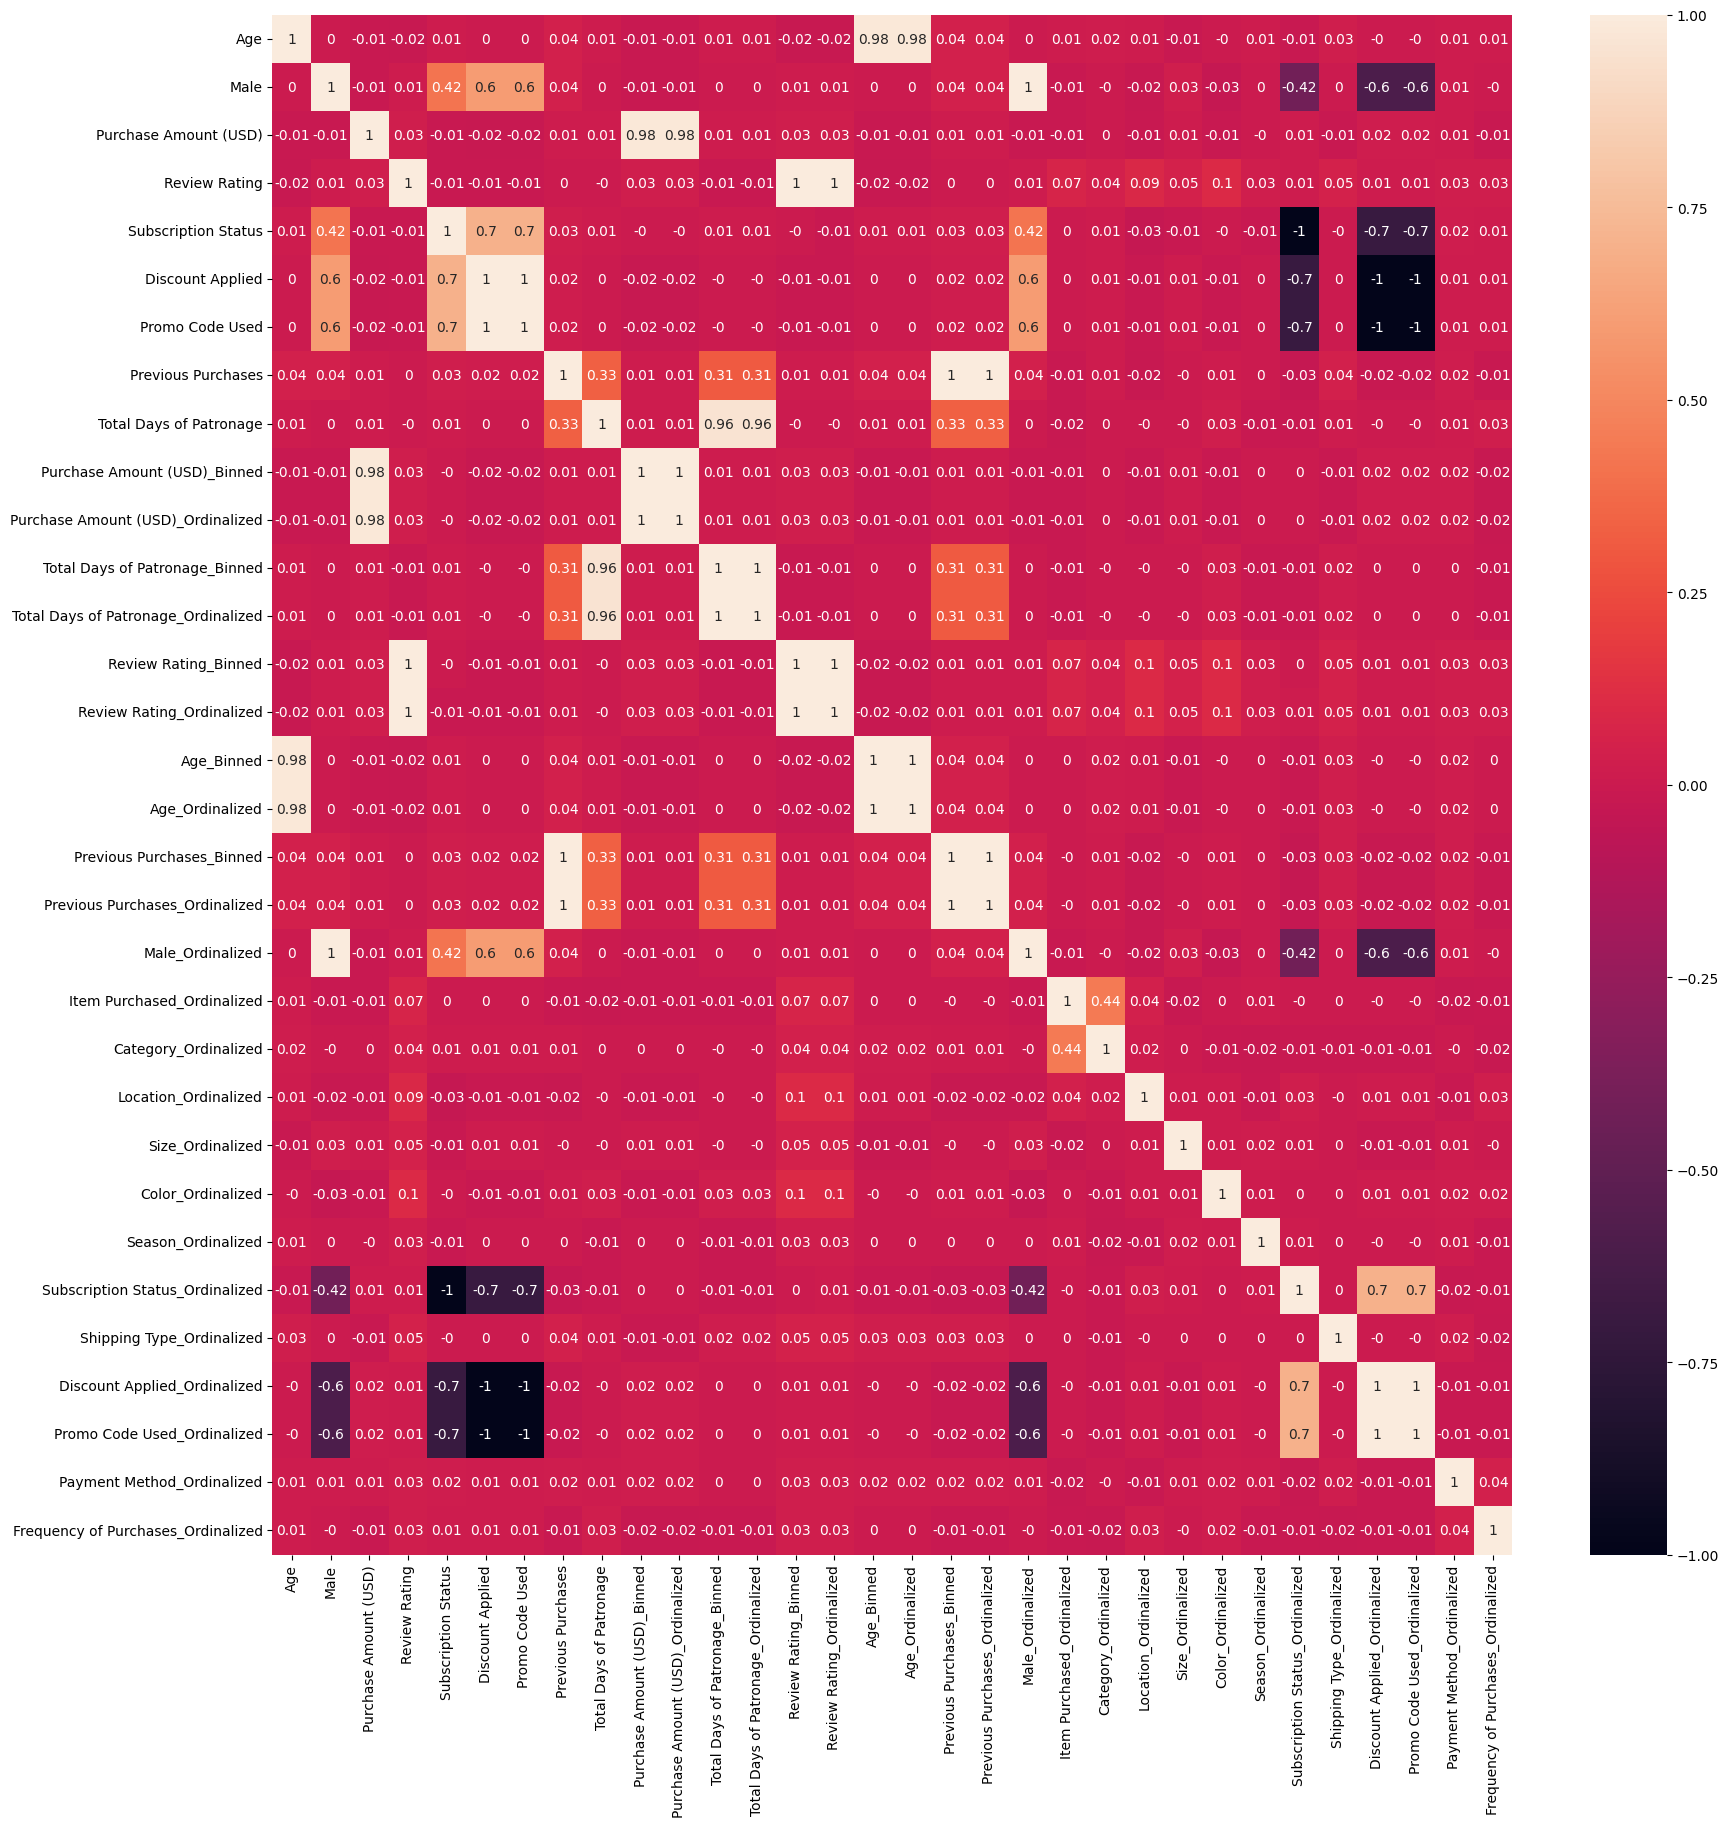

In [ ]:

plt.figure(figsize=(20,20))
sns.heatmap(round(regression_df.corr(),2),annot=True,linecolor='black')
plt.show()


### The heatmap above indicates that the variables most correlated to "Review Rating" are Color and Location. However, the correlations are  week. They are both only 0.1  

### An initial look at Color and Location    

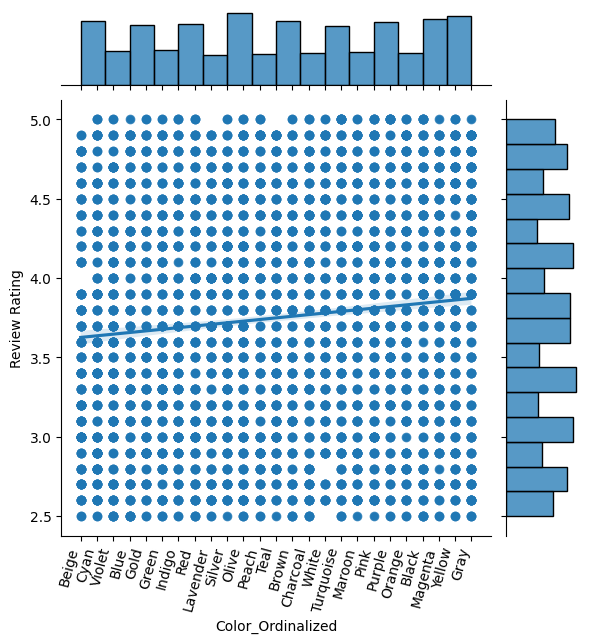

In [ ]:
x_axis=regAna.ordinalization_lookup_maps['Color_Ordinalized'].sort_values(by='Color_Ordinalized')
sns.jointplot(regression_df,x='Color_Ordinalized',y='Review Rating')
sns.regplot(regression_df,x='Color_Ordinalized',y='Review Rating')
plt.xticks(x_axis['Color_Ordinalized'].values,labels=list(x_axis['Color'].values), rotation=75,ha='right')
plt.show()


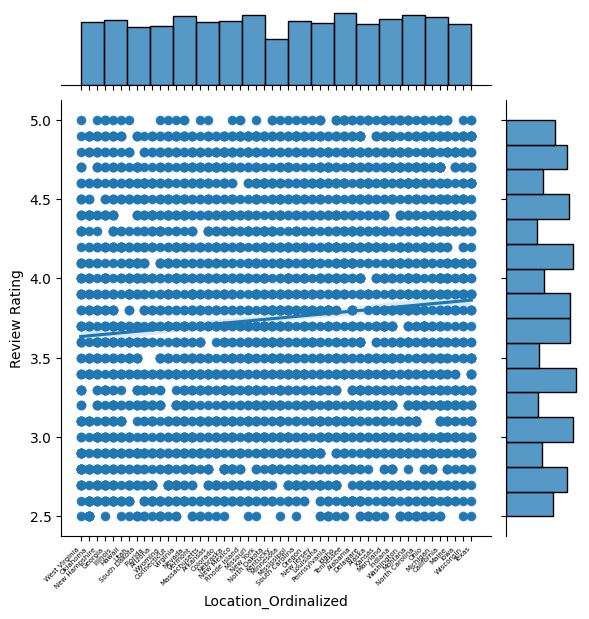

In [ ]:
x_axis=regAna.ordinalization_lookup_maps['Location_Ordinalized'].sort_values(by='Location_Ordinalized')
sns.jointplot(regression_df,x='Location_Ordinalized',y='Review Rating')
sns.regplot(regression_df,x='Location_Ordinalized',y='Review Rating')
plt.xticks(x_axis['Location_Ordinalized'].values,labels=list(x_axis['Location'].values), rotation=45,ha='right',fontsize=5)
plt.show()

## Build predictive models  

In [ ]:
y=regression_df['Review Rating']
X=regression_df.drop(columns=['Review Rating',  'Review Rating_Binned', 'Review Rating_Ordinalized' ])

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

scaler = StandardScaler()

Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)



In [ ]:
# a function to evaluate model regularization
def model_evaluator(Xtrain_scaled,Xtest_scaled,ytrain,ytest,model_,params):
    """
    """
    model=model_
    model.fit(Xtrain_scaled,ytrain)
    train_r2 = model.score(Xtrain_scaled,ytrain)
    test_r2  = model.score(Xtest_scaled,ytest)
    return params, {'train':train_r2,'test':test_r2}

In [ ]:
"""
print('Ridge')
for alpha in [0.0001,10,350,439,500,1000]:
    res=model_evaluator(Xtrain_scaled,Xtest_scaled,ytrain,ytest,Ridge(alpha=alpha),{'alpha':alpha})
    print(res)

print('*'*20,'\nRF')
for min_samples_leaf in [1]+list(range(10,20)):
    res=model_evaluator(Xtrain_scaled,Xtest_scaled,ytrain,ytest,RandomForestRegressor(max_depth=3,min_samples_leaf=min_samples_leaf),{'max_depth':3,'min_samples_leaf':min_samples_leaf})
    print(res)
"""

"\nprint('Ridge')\nfor alpha in [0.0001,10,350,439,500,1000]:\n    res=model_evaluator(Xtrain_scaled,Xtest_scaled,ytrain,ytest,Ridge(alpha=alpha),{'alpha':alpha})\n    print(res)\n\nprint('*'*20,'\nRF')\nfor min_samples_leaf in [1]+list(range(10,20)):\n    res=model_evaluator(Xtrain_scaled,Xtest_scaled,ytrain,ytest,RandomForestRegressor(max_depth=3,min_samples_leaf=min_samples_leaf),{'max_depth':3,'min_samples_leaf':min_samples_leaf})\n    print(res)\n"

## A High variance model  

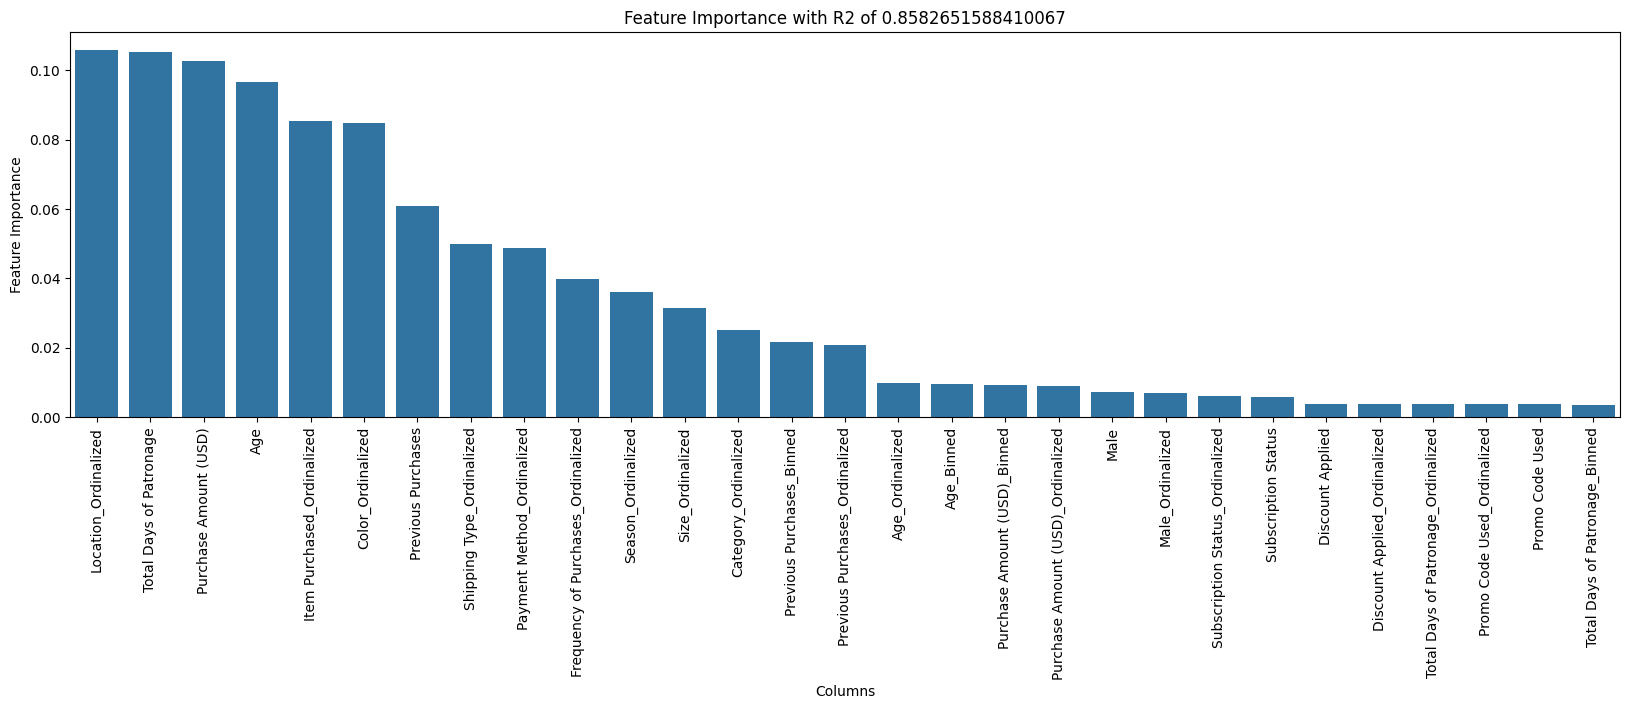

In [ ]:
rfr=RandomForestRegressor()
y2=regression_df['Review Rating']
X2=regression_df.drop(columns=['Review Rating','Review Rating_Binned','Review Rating_Ordinalized'])
rfr.fit(X2,y2)
score=rfr.score(X2,y2)
rfr_features=rfr.feature_importances_
importance_df = pd.DataFrame({'Importance':rfr_features,'Columns':X2.columns}).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(20,5))
sns.barplot(x=importance_df['Columns'],y=importance_df['Importance'])
plt.title(f'Feature Importance with R2 of {score}')
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)
plt.show()

> Noteworthy: If all of the following 'influential' columns are removed, the R2 is below .65, but if any one of them is reintroduced, the R2 is above 0.80.   

In [ ]:
influential=[ 'Purchase Amount (USD)', 'Total Days of Patronage', 'Location_Ordinalized',
             'Age','Color_Ordinalized','Item Purchased_Ordinalized',
             'Previous Purchases','Previous Purchases_Binned','Previous Purchases_Ordinalized',
             'Payment Method_Ordinalized','Shipping Type_Ordinalized', 'Frequency of Purchases_Ordinalized']

## A regularized model 

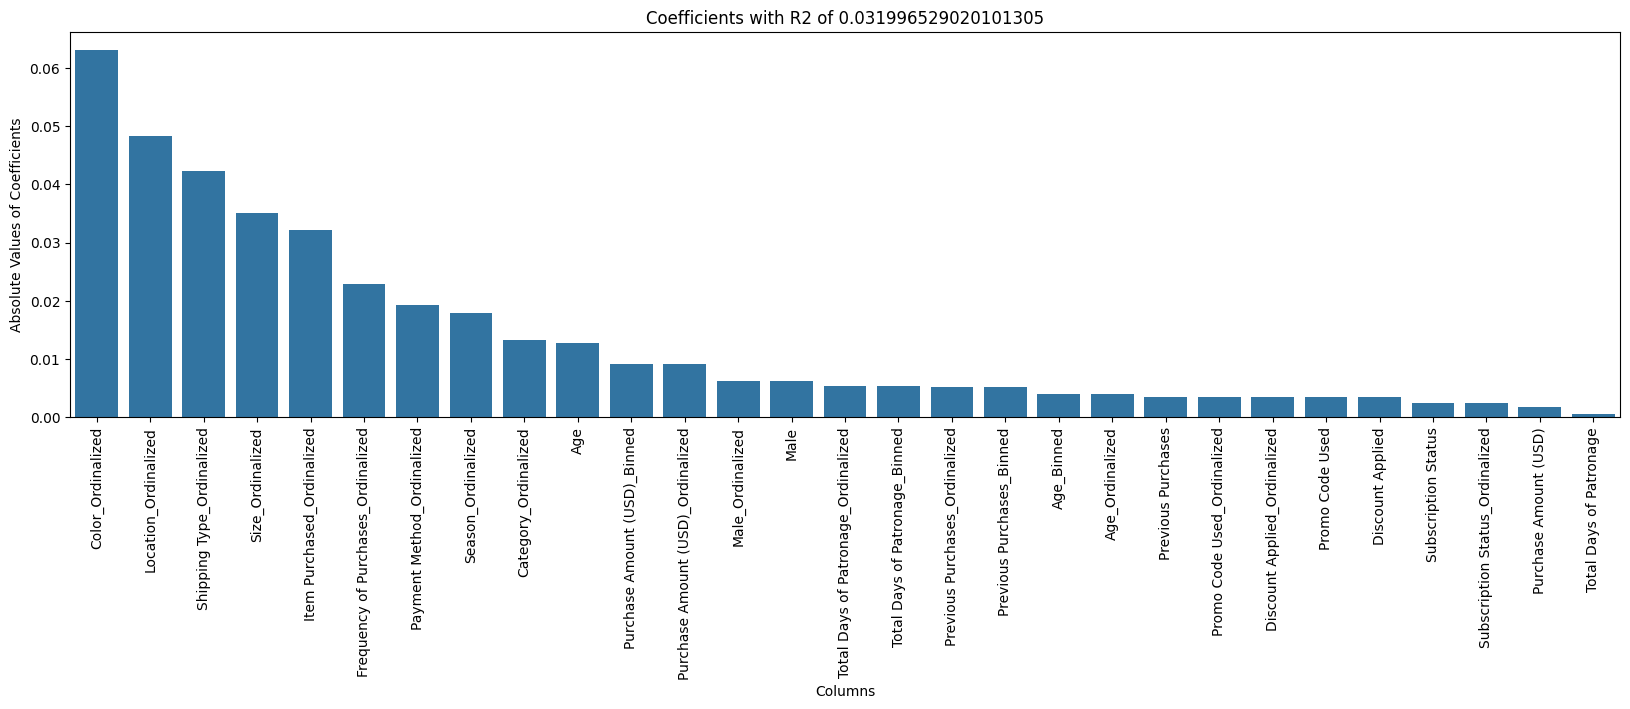

In [ ]:
regression=Ridge(alpha=500)
regression.fit(Xtrain_scaled,ytrain)
score1=regression.score(scaler.transform(X),y)
plt.figure(figsize=(20,5))
coeff_df=pd.DataFrame({'Coefficients':list(regression.coef_),'Columns':list(Xtrain.columns)})
coeff_df['Coefficients'] = abs(coeff_df['Coefficients'])
coeff_df=coeff_df.sort_values(by="Coefficients",ascending=False)
sns.barplot(x=coeff_df['Columns'],y=coeff_df['Coefficients'])
plt.title(f'Coefficients with R2 of {score1}')
plt.ylabel('Absolute Values of Coefficients')
plt.xticks(rotation=90)
plt.show()

>### There is little predictive power in the regularized model, but noticable differences in correlation

### Bar plots with confidence bars

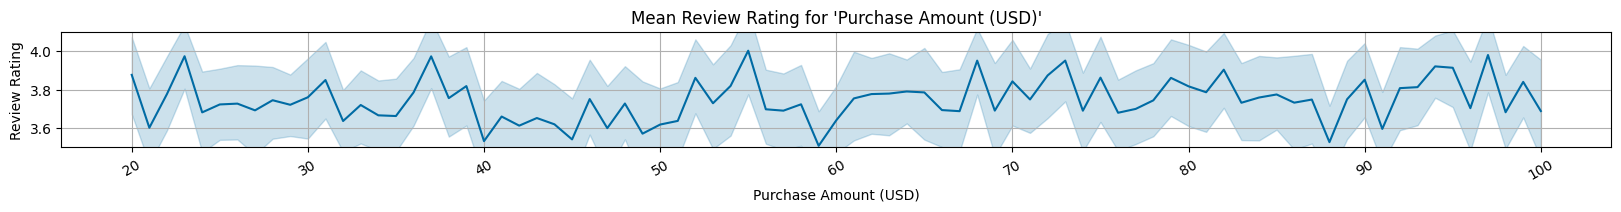

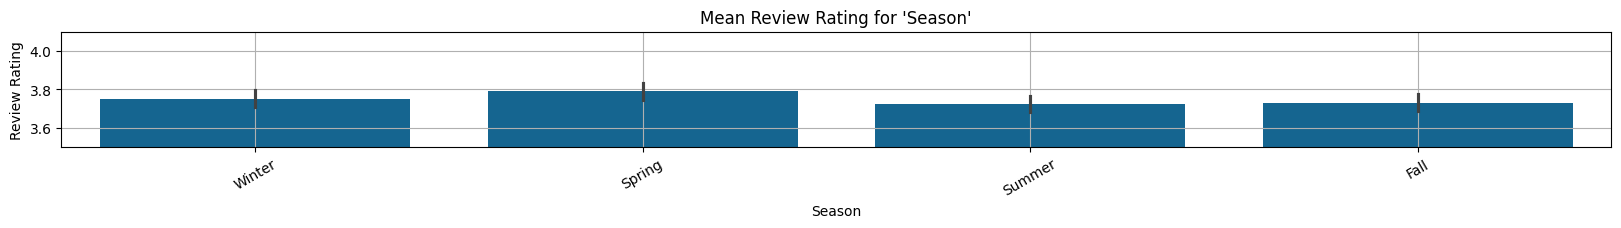

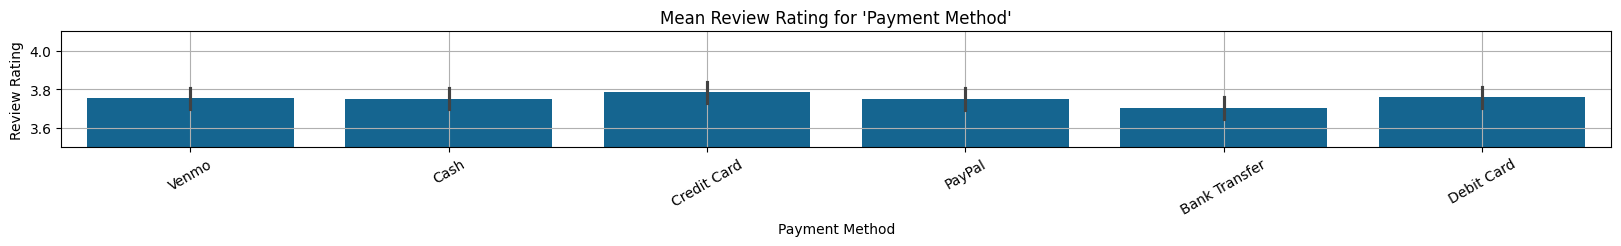

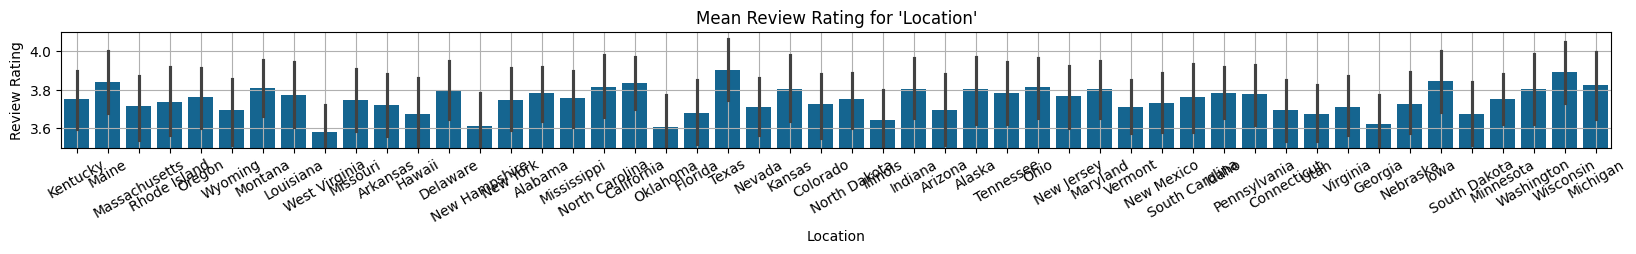

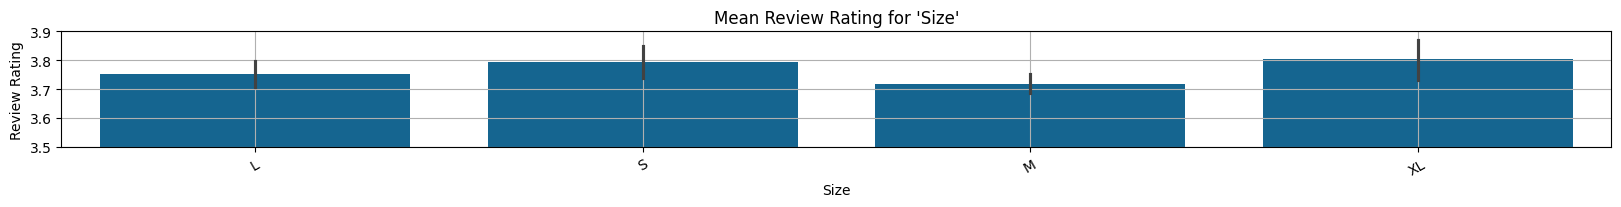

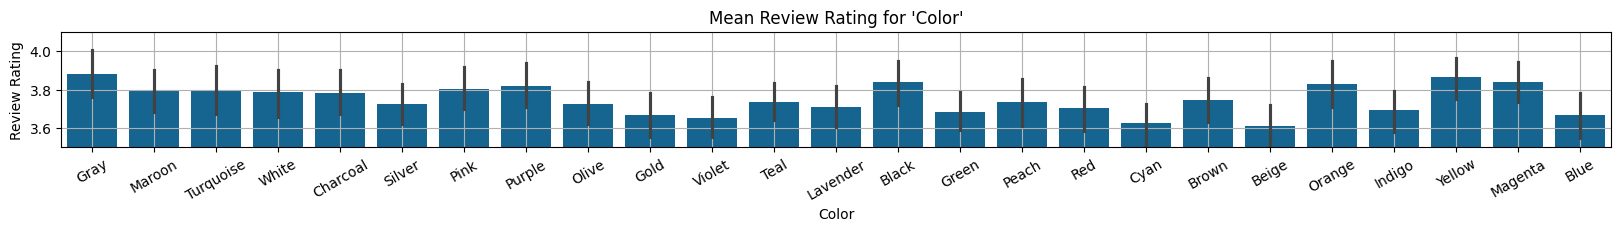

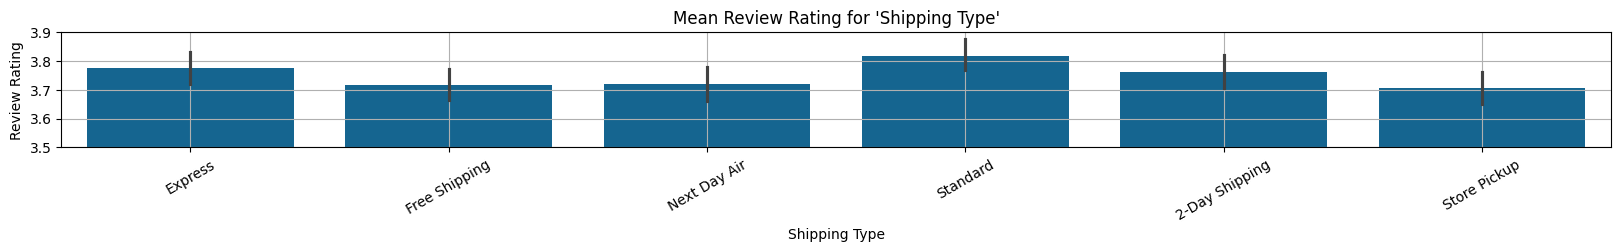

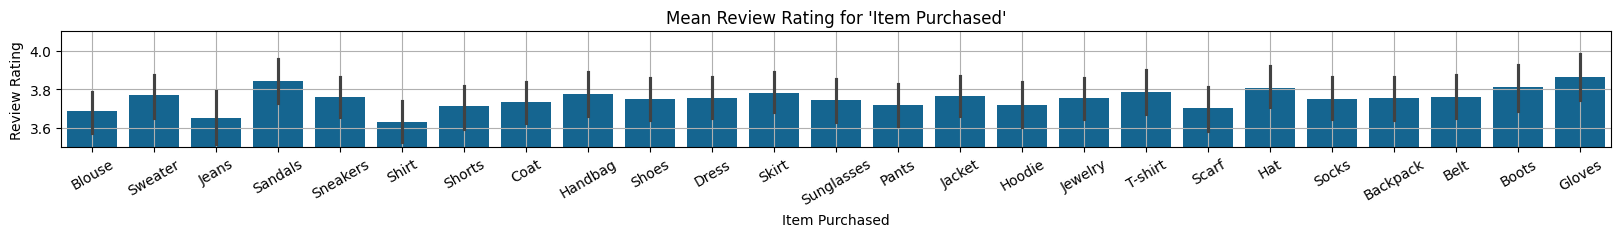

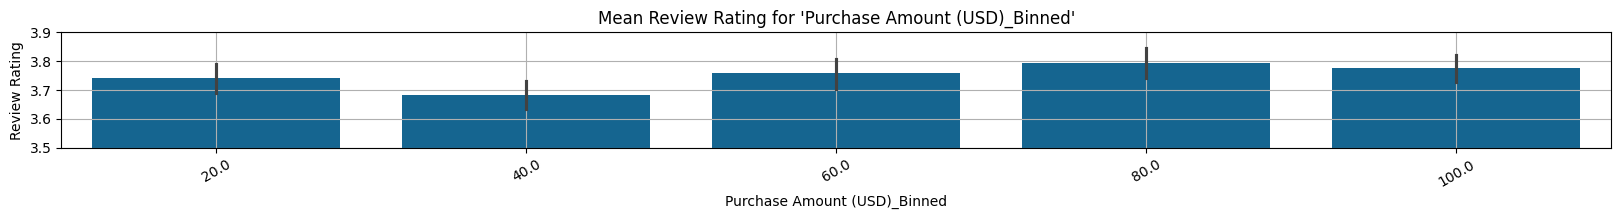

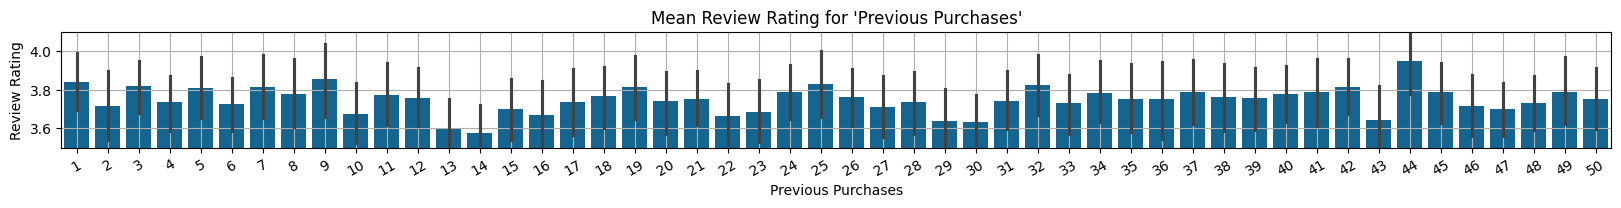

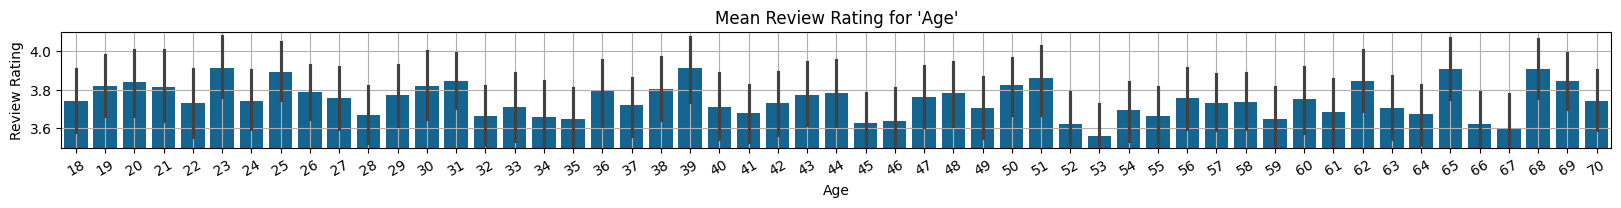

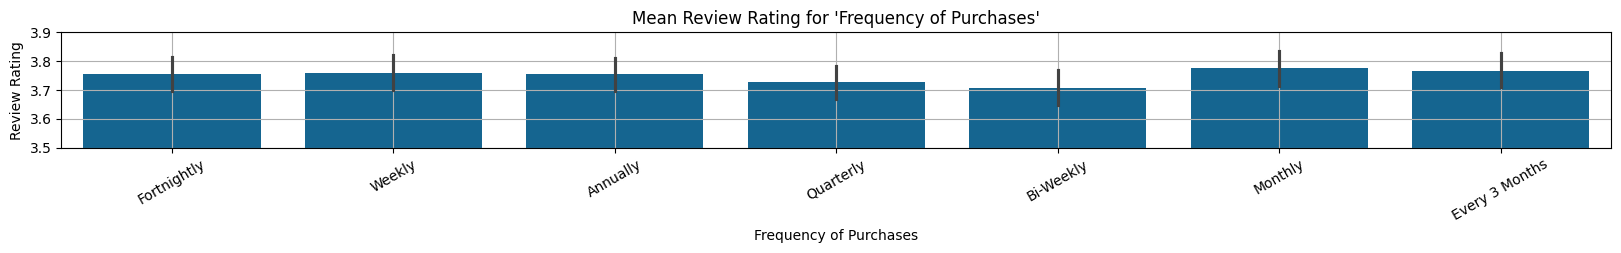

In [ ]:
x_axises= [ 'Purchase Amount (USD)','Season', 'Payment Method','Location', 'Size', 'Color','Shipping Type', 'Item Purchased', 'Purchase Amount (USD)_Binned', 'Previous Purchases', 'Age', 'Frequency of Purchases']
plt.style.use('tableau-colorblind10')
for x_axis in x_axises:
    plt.figure(figsize=(20,1.5))
    plt.title(f"Mean Review Rating for '{x_axis}'")
    if x_axis in ('Purchase Amount (USD)','Total Days of Patronage'):
        sns.lineplot(data=df,x=df[x_axis],y=df['Review Rating'],estimator='mean',errorbar=('ci',95))
    else:
        sns.barplot(data=df,x=df[x_axis],y=df['Review Rating'],estimator='mean',errorbar=('ci',95))
    plt.xticks(rotation=30)
    if x_axis in ('Frequency of Purchases','Shipping Type','Purchase Amount (USD)_Binned','Size'):
        plt.ylim((3.5,3.9))
    else:
        plt.ylim((3.5,4.1))
    plt.grid()
    plt.show()


## Conclusion:  
>## Many subcategory means are grouped within a few 10ths places  

# ============================================================================================================  
# ============================================================================================================  

>## ***Exploratory* Insights**  


# Colors  
>A Closer look at "Color" because it seems to be have a stronger **Linear** relation to 'Review Rating' than other variables do.   

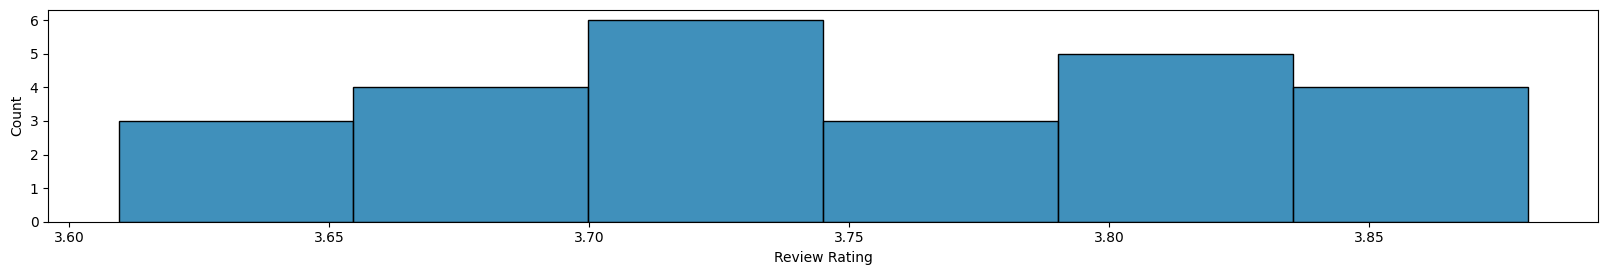

Color,Beige,Cyan,Violet,Blue,Gold,Green,Indigo,Red,Lavender,Silver,Olive,Peach,Teal,Brown,Charcoal,White,Turquoise,Maroon,Pink,Purple,Orange,Black,Magenta,Yellow,Gray
Review Rating,3.609524,3.626506,3.653012,3.667763,3.67029,3.684615,3.692517,3.70473,3.710884,3.724855,3.724859,3.734899,3.737791,3.748936,3.783007,3.78662,3.798621,3.800633,3.802614,3.821854,3.828571,3.84012,3.840789,3.864368,3.880503


In [ ]:
color_review_means=df.groupby('Color')['Review Rating'].mean()
plt.figure(figsize=(20,2.75))
sns.histplot(color_review_means)
plt.show()
pd.set_option('display.max_columns',100)
color_review=color_review_means.sort_values().to_frame()
display(color_review.T)

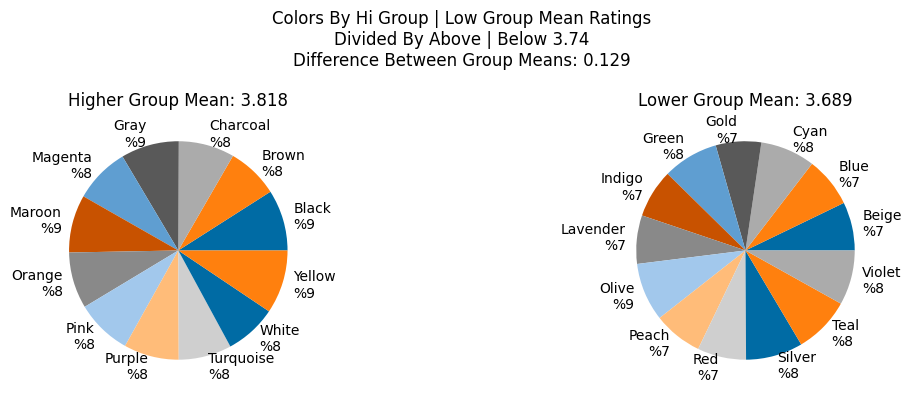

In [ ]:
midpoint=3.74
low=color_review.loc[color_review['Review Rating']<midpoint].index
higher=color_review.loc[color_review['Review Rating']>=midpoint].index
low_mean_rev=df.loc[df['Color'].isin(low)]['Review Rating'].mean()
high_mean_rev=df.loc[df['Color'].isin(higher)]['Review Rating'].mean()
#print(f"Low Review Color Group's Mean: {low_mean_rev}.\nHigher Review Color Group's Mean: {high_mean_rev}\nDifference: {high_mean_rev-low_mean_rev}.")
low_color_proportions=df.loc[df['Color'].isin(low)].groupby('Color').size()
low_color_proportions=low_color_proportions/low_color_proportions.sum()
low_x,low_labels = low_color_proportions.values, low_color_proportions.index
higher_color_proportions=df.loc[df['Color'].isin(higher)].groupby('Color').size()
higher_color_proportions=higher_color_proportions/higher_color_proportions.sum()
higher_x,higher_labels = higher_color_proportions.values, higher_color_proportions.index
plt.figure(figsize=(12,4))
plt.suptitle(f'Colors By Hi Group | Low Group Mean Ratings\nDivided By Above | Below {midpoint}\nDifference Between Group Means: {round(high_mean_rev-low_mean_rev,3)}')
plt.subplot(1,2,1)
h_labels=[f"{kh}\n%{100*vh:.0f}" for kh,vh in zip(higher_labels,higher_x)]
plt.title(f'Higher Group Mean: {round(high_mean_rev,3)}')
plt.pie(x=higher_x,labels=h_labels)
plt.subplot(1,2,2)
l_labels=[f"{kh}\n%{100*vh:.0f}" for kh,vh in zip(low_labels,low_x)]
plt.title(f'Lower Group Mean: {round(low_mean_rev,3)}')
plt.pie(x=low_x,labels=l_labels)
plt.tight_layout()
plt.show()

# Other Variables

Following plots show the mean distributions for categorical variables such as Location and Color.  
Some variables have poor performing categories:  
### **Examples**  
 
| **Variable** | **Number of Poor Performing Subategories** |  
|----------------|----------------------------------|  
| Item Purchased | 2                                |    
| Location       | 4                                |    
| Season         | 2                                |    
| Shipping Type  | 3                                |    

### **The Next Cell Identifies Them:**

In [ ]:
ip=df.groupby('Item Purchased',as_index=False)['Review Rating'].mean().sort_values(by='Review Rating',ascending=True).head(2)
lo=df.groupby('Location',as_index=False)['Review Rating'].mean().sort_values(by='Review Rating',ascending=True).head(4)
se=df.groupby('Season',as_index=False)['Review Rating'].mean().sort_values(by='Review Rating',ascending=True).head(2)
st=df.groupby('Shipping Type',as_index=False)['Review Rating'].mean().sort_values(by='Review Rating',ascending=True).head(3)
low_performers=list(ip.iloc[:,0].values)+list(lo.iloc[:,0].values)+list(se.iloc[:,0].values)+list(st.iloc[:,0].values)
for slice in [ip,lo,se,st]:
    display(slice)

,Item Purchased,Review Rating
16,Shirt,3.629586
11,Jeans,3.648387


,Location,Review Rating
47,West Virginia,3.580247
35,Oklahoma,3.605333
28,New Hampshire,3.611268
9,Georgia,3.624051


,Season,Review Rating
2,Summer,3.725654
0,Fall,3.729949


,Shipping Type,Review Rating
5,Store Pickup,3.706462
2,Free Shipping,3.717926
3,Next Day Air,3.720833


### These are the plots information in proceeding cells was derived from.  The plots show the mean distribution for categorical variables

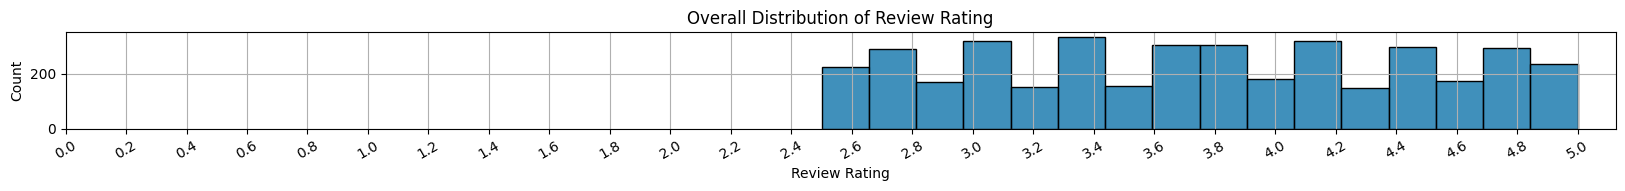

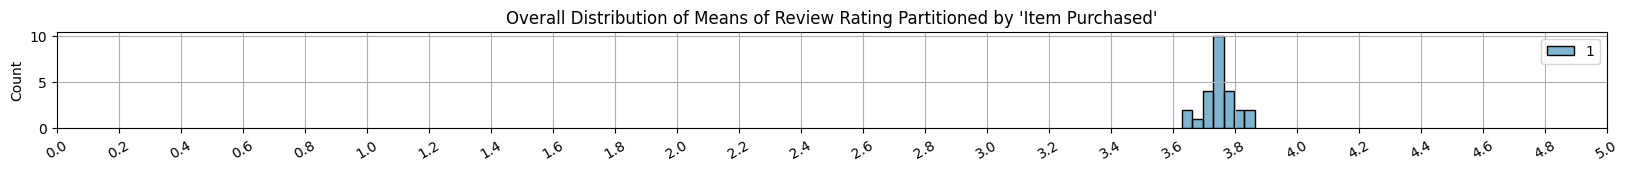

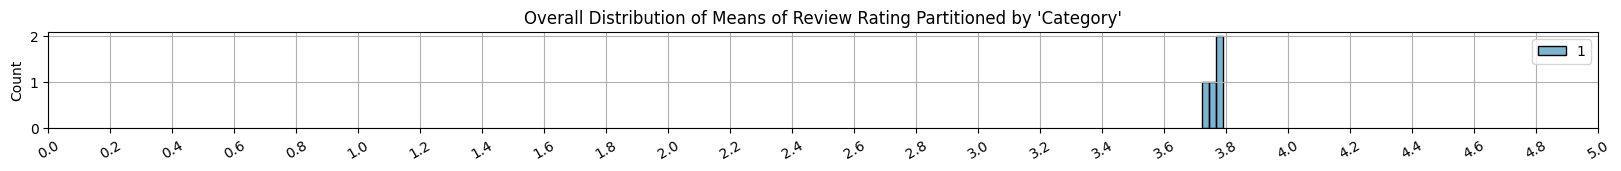

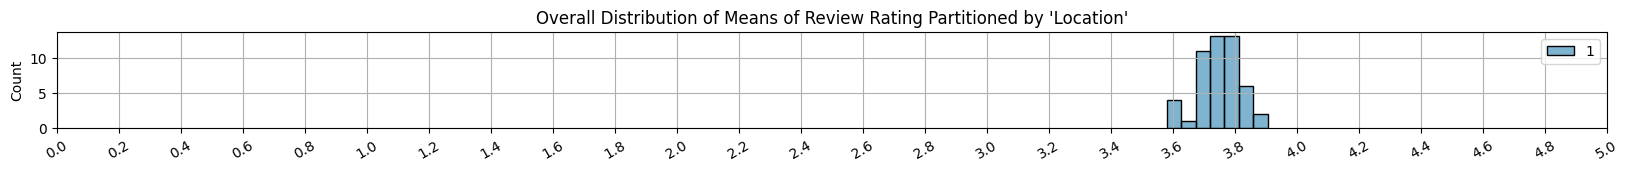

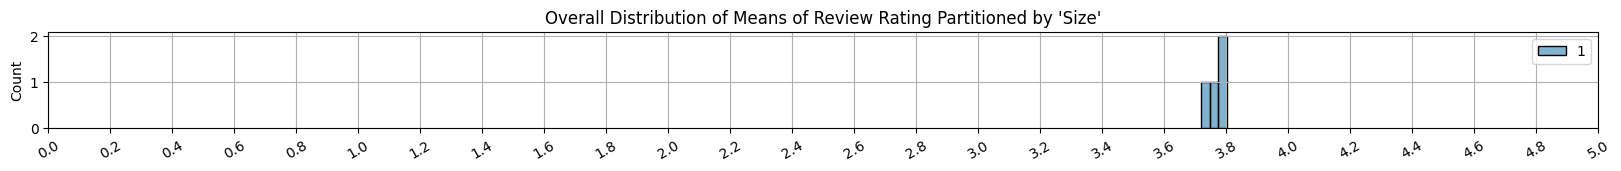

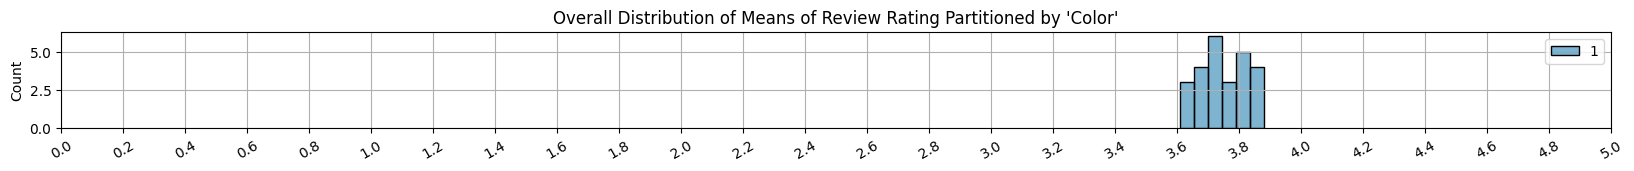

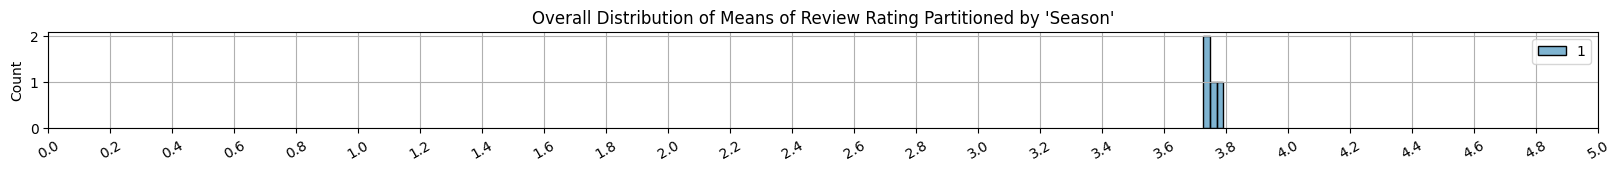

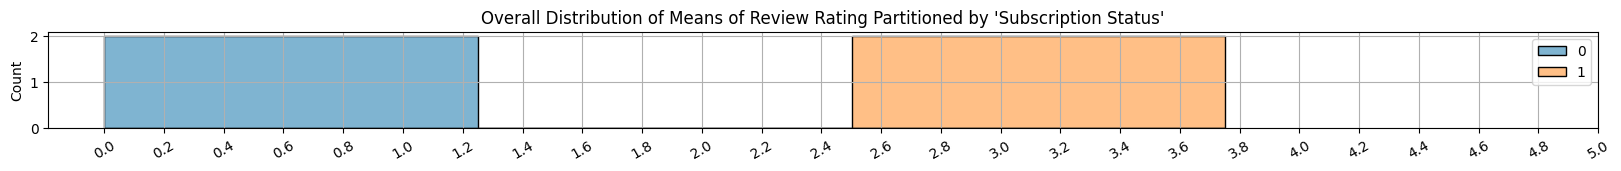

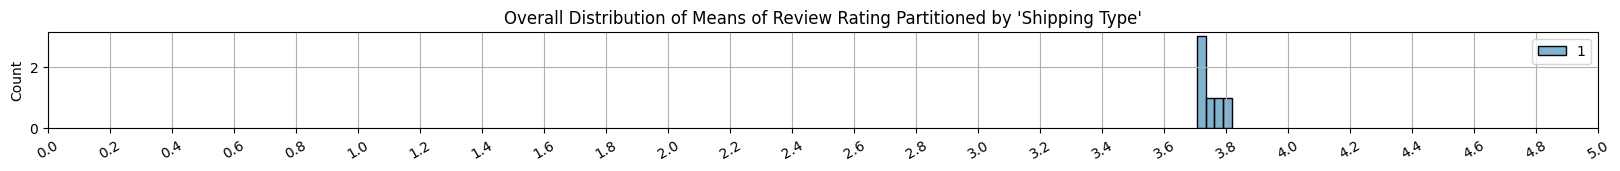

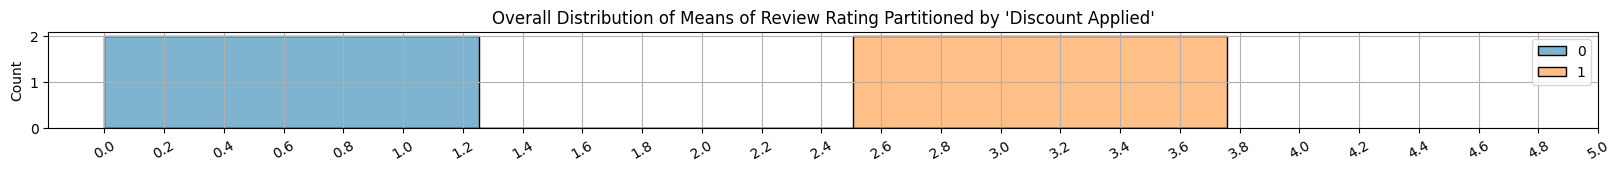

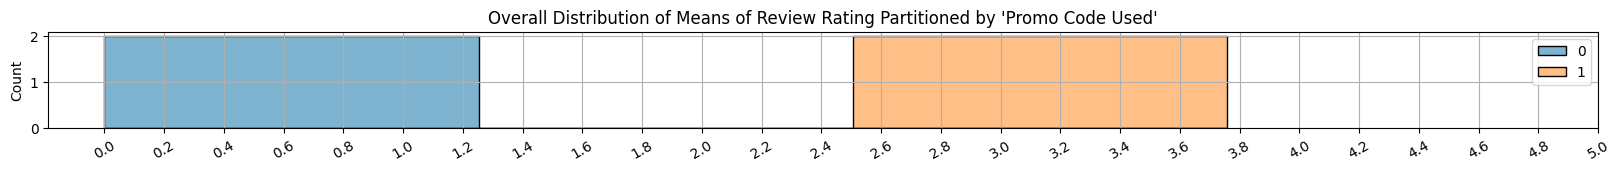

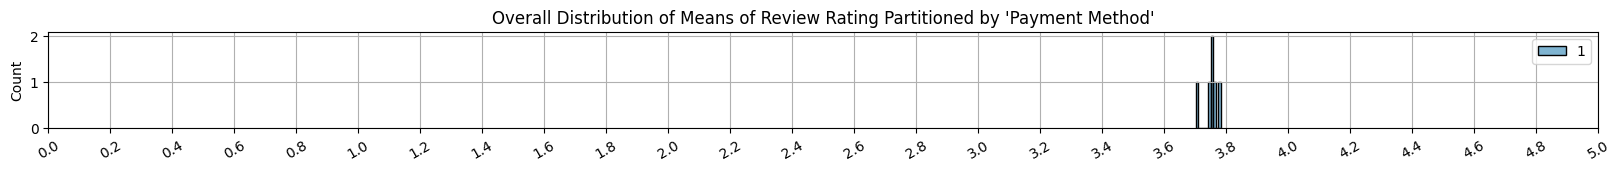

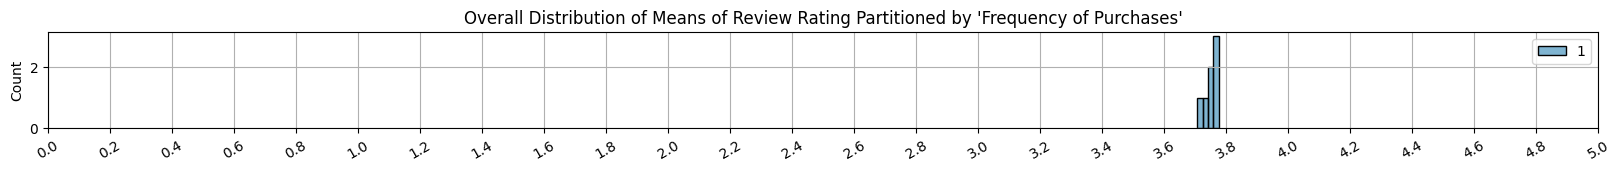

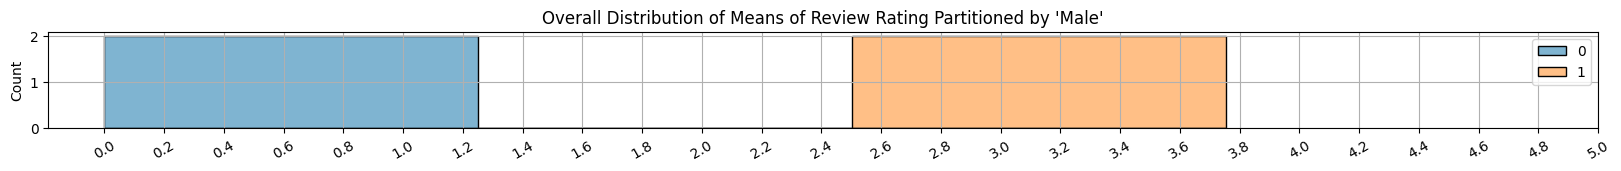

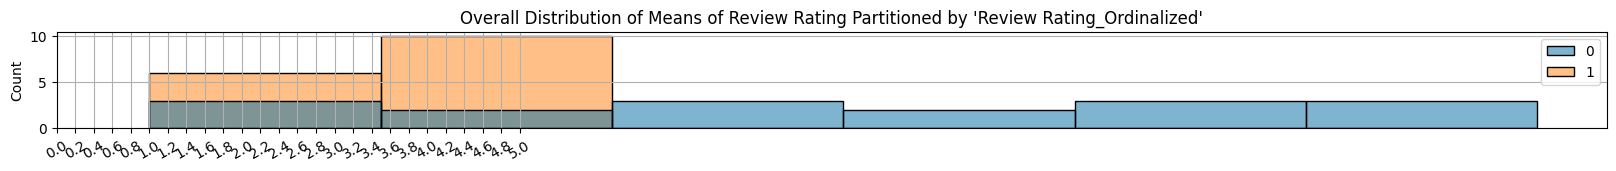

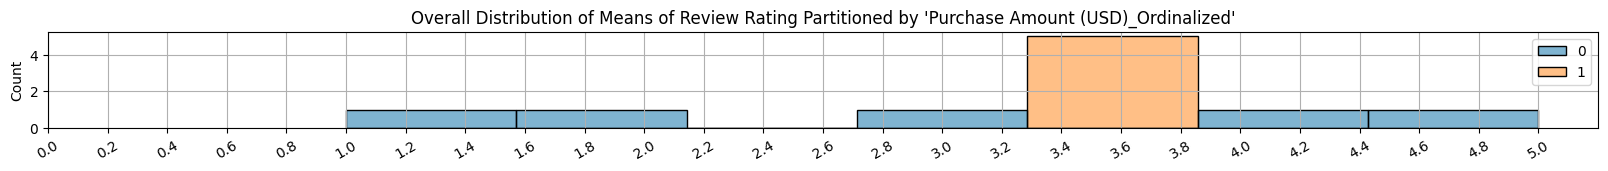

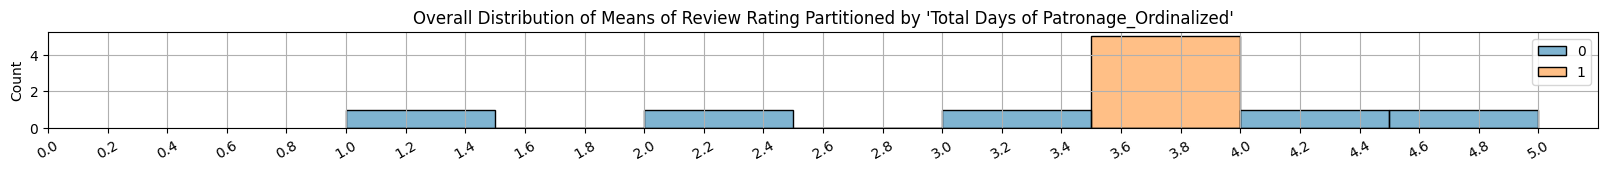

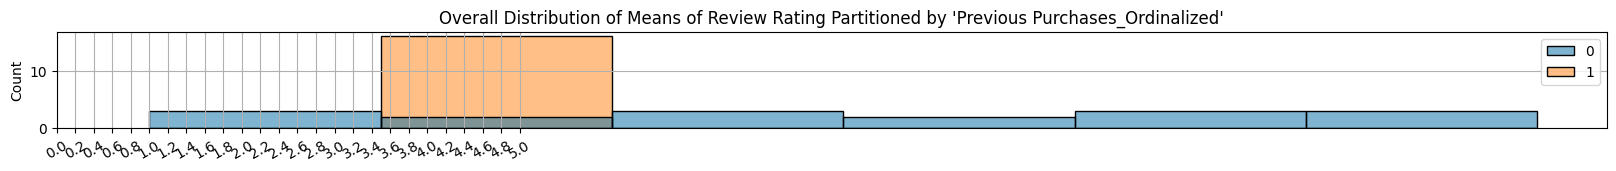

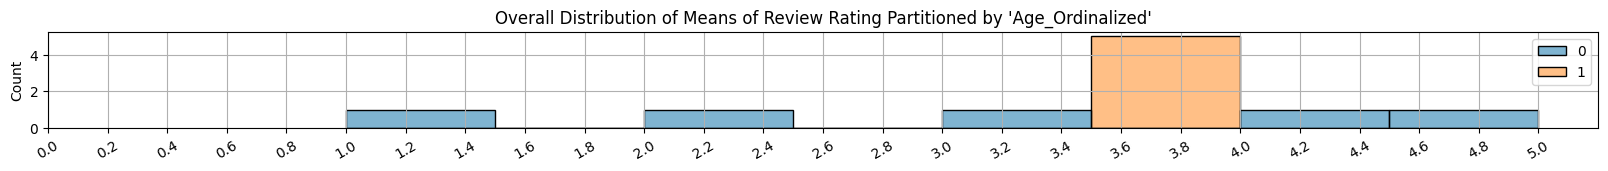

In [ ]:
countplot=False
#feature_col='Location'
target_col='Review Rating'
x_ticks=np.linspace(0,5,26)
percentile_bins=[0,25,50,75,100]

plt.figure(figsize=(20,1.25))
plt.title(f"Overall Distribution of {target_col}")
sns.histplot(df[target_col])
plt.xticks(x_ticks,rotation=30)
plt.grid()
plt.show()

cols=3
rows=int(np.ceil(len(x_axises)/cols))
for feature_col in df.select_dtypes('object').columns:
    x_axises = df[feature_col].unique()
    plt.figure(figsize=(20,1.25))
    plt.title(f"Overall Distribution of Means of {target_col} Partitioned by '{feature_col}'")
    odom=df.groupby(feature_col,as_index=False)[target_col].mean().values
    sns.histplot(odom)
    plt.xticks(x_ticks,rotation=30)
    plt.grid()
    plt.show()

## A Look at Sales Portions for Variables With ***Visible*** Low Performing Bins as Seen In the Above Histograms   

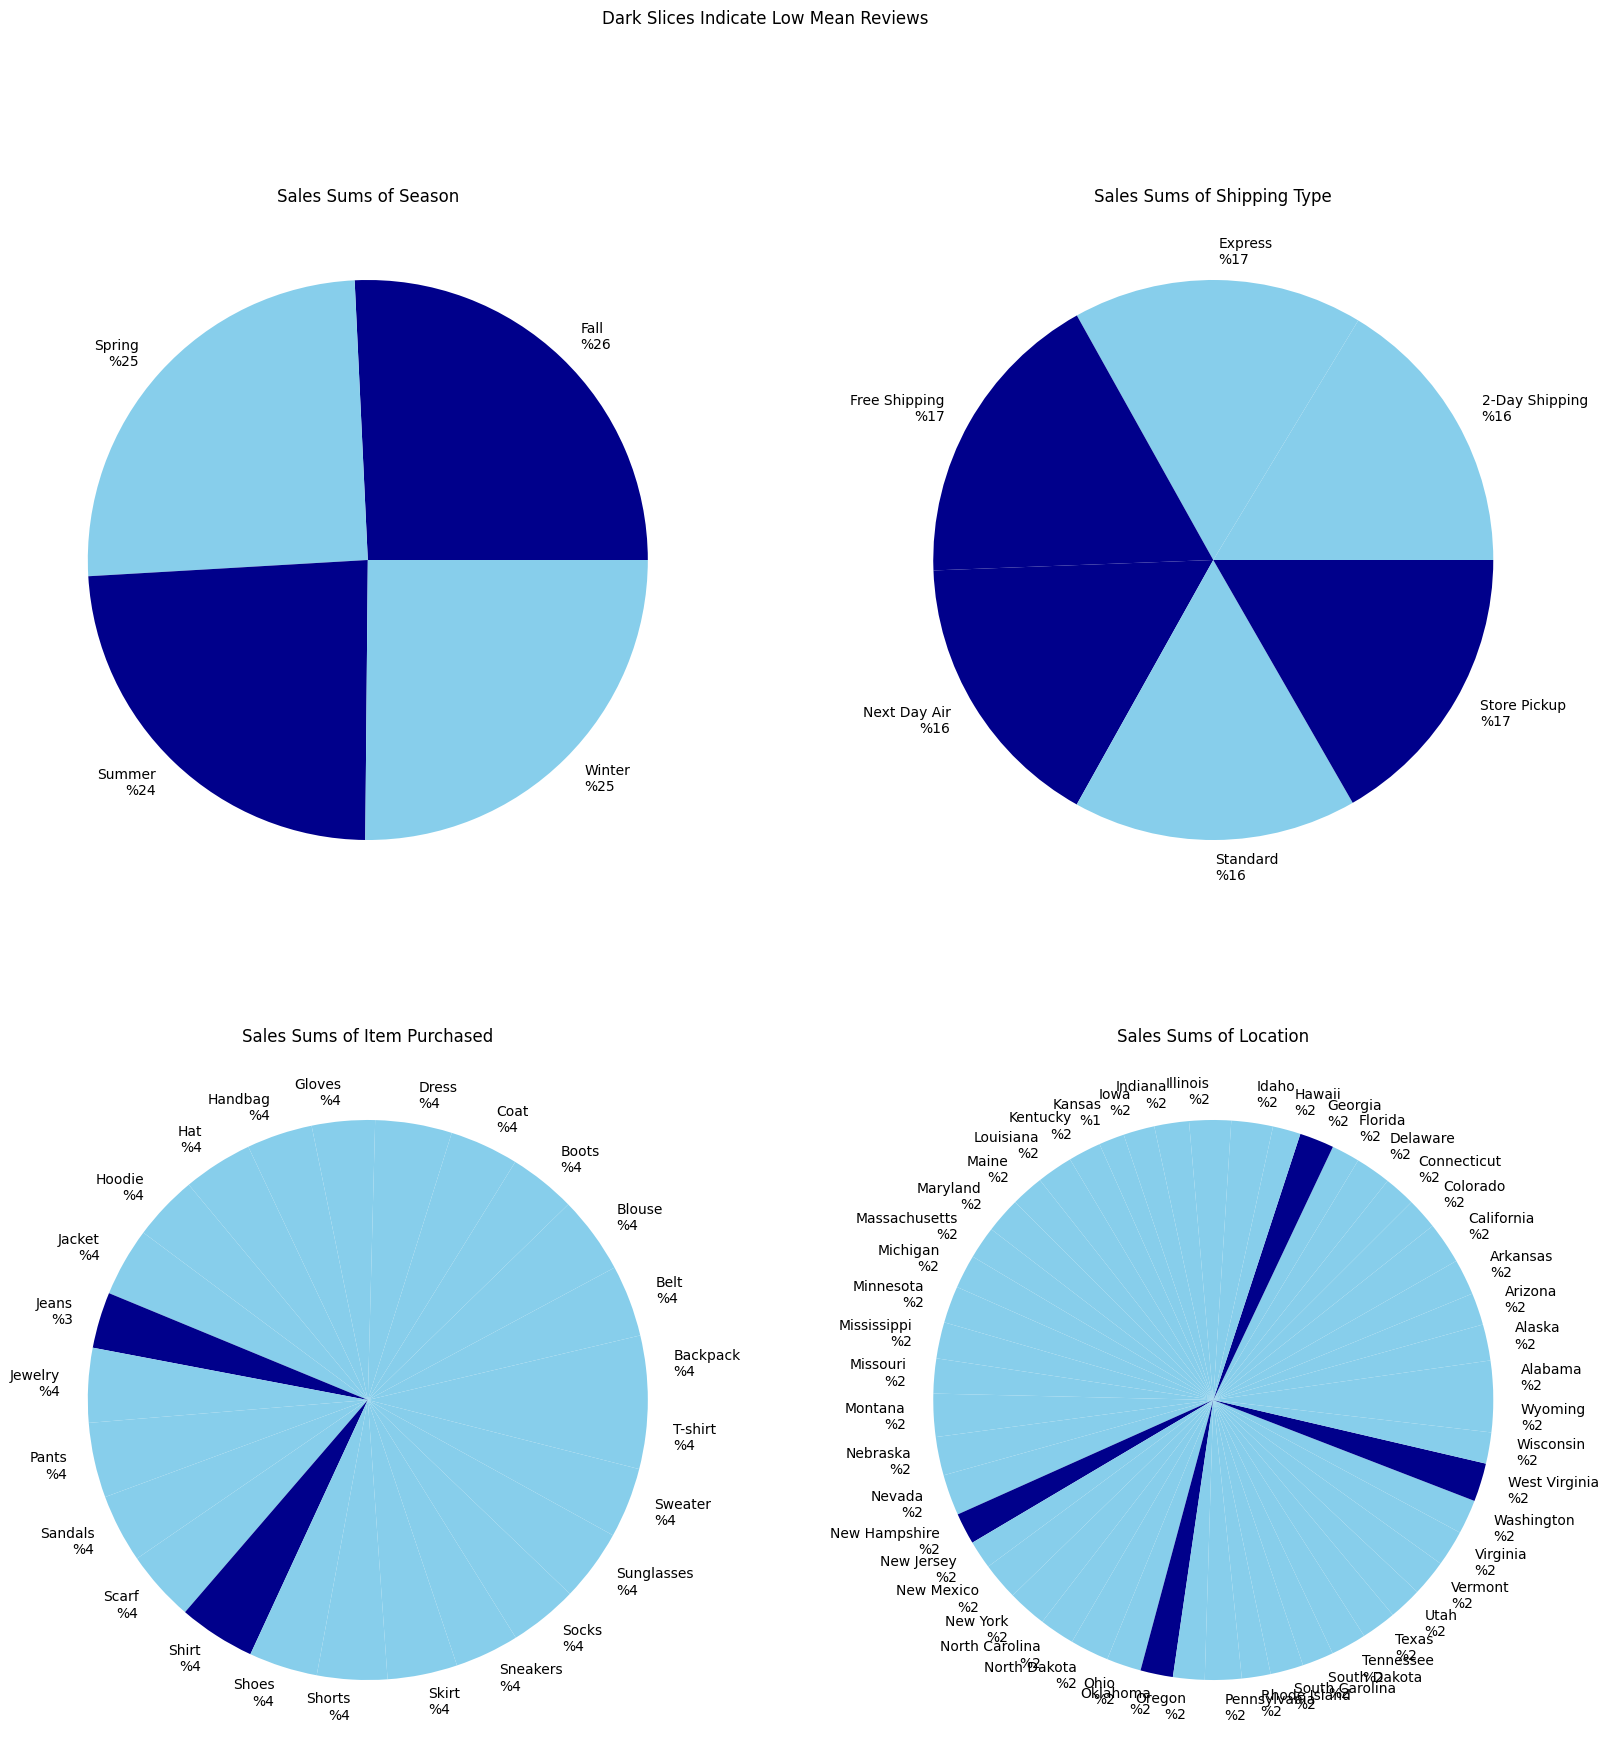

In [ ]:
pie_variables=["Season","Shipping Type","Item Purchased","Location"]
cols=2
rows=int(np.ceil(len(pie_variables)//cols))
width=20
plt.figure(figsize=(width,rows*(width/cols)))
plt.suptitle('Dark Slices Indicate Low Mean Reviews')
for plot_axis,partition_variable in enumerate(pie_variables,start=1):
    pie_data=df.groupby(partition_variable)['Purchase Amount (USD)'].sum()
    pie_data=pie_data / pie_data.sum()
    plt.subplot(rows,cols,plot_axis)
    colors = ['skyblue' if value not in low_performers   else 'darkblue' for value in pie_data.index]
    labels=[f"{k}\n%{v*100:.0f}" for k,v in zip(pie_data.index,pie_data.values)]
    plt.title(f"Sales Sums of {partition_variable}")
    plt.pie(x=pie_data.values,labels=labels,colors=colors)
plt.show()

# Recomendations:  
>See the block at the top of this notebook for potential next steps    
It is titled: 'Next steps this data might lead to, enable, or enhance' 